In [37]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 10)

# Optional: also set width to avoid line wrapping
pd.set_option('display.width', 10)

# Optional: disable column width truncation
pd.set_option('display.max_colwidth', 10)

In [ ]:
all_players = nfl.import_players()
all_qbs = all_players[all_players['position'] == 'QB']
all_qbs.reset_index(inplace=True, drop='index')
all_qbs_id = list(all_qbs.gsis_id)

In [233]:
weekly_data = nfl.import_weekly_data(years=[2024])
weekly_data['completion_pct'] = weekly_data.completions / weekly_data.attempts
weekly_relevant = weekly_data[weekly_data['player_id'].isin(all_qbs_id)][['player_id', 'passing_tds', 'interceptions', 
                                                                          'sacks', 'sack_fumbles', 'rushing_tds', 
                                                                          'rushing_fumbles', 'completion_pct', 'passing_air_yards', 'attempts',
                                                                          'passing_yards']]
weekly_relevant = weekly_relevant.groupby('player_id').agg({
    'passing_tds' : 'sum', 
    'interceptions' : 'sum',
    'sacks' : 'sum',
    'sack_fumbles' : 'sum',
    'rushing_tds' : 'sum',
    'rushing_fumbles' : 'sum', 
    'completion_pct' : 'mean',
    'passing_air_yards' : 'sum',
    'attempts' : 'sum',
    'player_id' : 'count',
    'passing_yards' : 'sum'})
weekly_relevant = weekly_relevant.rename(columns={'player_id' : 'games_played'})
weekly_relevant = weekly_relevant[weekly_relevant['attempts'] > 100]


Downcasting floats.


In [234]:
stats2024 = nfl.import_pbp_data(years=[2024])
stats2024 = stats2024[(stats2024['qb_kneel'] == 0.0) & (stats2024['play_type'] != 'no_play')]
relevant = stats2024[['play_type', 'shotgun', 'qb_dropback', 'qb_scramble', 'air_yards', 'rushing_yards', 'id']]

2024 done.
Downcasting floats.


In [235]:
pass_stats = relevant[relevant['play_type'] == 'pass'].groupby('id').agg({'shotgun' : sum, 'qb_dropback' : sum})
pass_stats['shotgun'] = pass_stats.shotgun / pass_stats.qb_dropback
pass_stats.columns = ['shotgun_rate', 'total_passes']
pass_stats

,shotgun_rate,total_passes
id,,
00-0023459,0.842105,627.0
00-0026158,0.932584,267.0
00-0026300,0.500000,4.0
00-0026498,0.706731,624.0
00-0027973,0.797619,168.0
...,...,...
00-0039890,1.000000,1.0
00-0039910,0.962963,648.0
00-0039916,0.000000,1.0


In [236]:
run_stats = relevant[relevant['play_type'] == 'run'].groupby('id').agg({'qb_scramble' : ['sum', 'count'], 'rushing_yards' : 'sum'})
run_stats.columns = ['qb_scramble_sum', 'total_runs', 'rushing_yards']
run_stats['qb_scramble_rate'] = run_stats.qb_scramble_sum / run_stats.total_runs
run_stats = run_stats[['qb_scramble_rate', 'total_runs', 'rushing_yards']]
run_stats

,qb_scramble_rate,total_runs,rushing_yards
id,,,
00-0023459,0.941176,17,111.0
00-0026158,0.500000,6,29.0
00-0026300,0.000000,2,3.0
00-0026498,0.235294,17,64.0
00-0027973,0.857143,7,38.0
...,...,...,...
00-0039917,0.800000,5,14.0
00-0039918,0.666667,75,495.0
00-0039919,0.000000,3,15.0


In [269]:
total_data = weekly_relevant.join(pass_stats).join(run_stats)

total_data['sacks_per_dropback'] = total_data['sacks'] / total_data['total_passes']
total_data['sack_fumbles'] = total_data['sack_fumbles'] / total_data['total_passes']

total_data['interceptions_per_game'] = total_data['interceptions'] / total_data['games_played']
total_data['passing_tds_per_game'] = total_data['passing_tds'] / total_data['games_played']
total_data['passing_air_yards_per_attempt'] = total_data['passing_air_yards'] / total_data['attempts']
total_data['passing_yards_per_game'] = total_data['passing_yards'] / total_data['games_played']

total_data['rushing_tds_per_game'] = total_data['rushing_tds'] / total_data['games_played']
total_data['rushing_fumbles_per_game'] = total_data['rushing_fumbles'] / total_data['games_played']
total_data['rushing_yards_per_game'] = total_data['rushing_yards'] / total_data['games_played']
total_data['rushing_yards_per_attempt'] = total_data['rushing_yards'] / total_data['total_runs']

total_data['pass_pct'] = total_data.total_passes / (total_data.total_passes + total_data.total_runs)

total_data['runs_per_game'] = total_data['total_runs'] / total_data['games_played']
total_data['attempts_per_game'] = total_data['attempts'] / total_data['games_played']

total_data['td:int'] = total_data['passing_tds'] / total_data['interceptions']
total_data['air_yard:completion_pct'] = total_data['passing_air_yards_per_attempt'] / total_data['completion_pct']

total_data = total_data[['sacks_per_dropback', 'attempts_per_game', 'rushing_tds_per_game', 'passing_tds_per_game', 'interceptions', 
                         'shotgun_rate', 'passing_air_yards_per_attempt', 'completion_pct',
                         'rushing_fumbles_per_game', 'rushing_yards_per_game', 'rushing_yards_per_attempt', 'pass_pct',
                         'air_yard:completion_pct', 'td:int']]

In [270]:
qb_names = list(total_data.merge(all_qbs[['gsis_id', 'display_name']], left_index=True, right_on='gsis_id').display_name)

In [271]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [272]:
scaler = StandardScaler()
X = scaler.fit_transform(total_data)
for P in range(1, 10):
    pca = PCA(n_components=P)
    pca.fit(X)
    print(pca.explained_variance_ratio_.sum())

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)


0.2826494070854704
0.4749349844063204
0.5916008485658868
0.6883312024497541
0.7680862962570842
0.8338055205606958
0.8877100589184732
0.9383320754370097
0.9605072666117077


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of

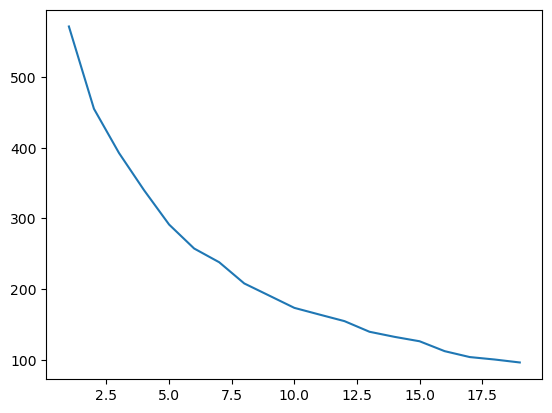

In [273]:
import plotly.express as px
intertia = []
for K in range(1,20):
    kmeans = KMeans(n_clusters=K)
    intertia.append(kmeans.fit(X= X_pca).inertia_)

kmeans = KMeans(n_clusters=5)
groups = kmeans.fit_predict(X=X_pca)
    
plt.plot(range(1,20), intertia)
plt.show()
fig = px.scatter(x=X_pca[:, 0], y=X_pca[:,1], color=groups, hover_name=qb_names)
fig.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 0, 2, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 2,
       1, 1], dtype=int32)